# Синхронизация с гит

In [2]:
# --- БЛОК №1: НАЧАЛО РАБОТЫ (выполнять в каждой новой сессии) ---

from google.colab import drive, userdata
import os

# 1. Монтируем Google Drive
drive.mount('/content/drive')

# 2. Получаем секретный токен
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

# 3. Указываем ваше имя и email (как на GitHub)
GIT_USERNAME = "kirichich1" # <-- Ваше имя пользователя
GIT_EMAIL = "kirichich@bk.ru" # <-- Ваша почта

# 4. !!! ПРЕДСТАВЛЯЕМСЯ СИСТЕМЕ GIT !!!
# Эта конфигурация будет действовать до конца текущей сессии
!git config --global user.name "{GIT_USERNAME}"
!git config --global user.email "{GIT_EMAIL}"

# 5. Переходим в директорию проекта
PROJECT_PATH = "/content/drive/MyDrive/GitHub/no2_prediction_pipeline"
%cd {PROJECT_PATH}

# 6. (Рекомендуется) Скачиваем последние изменения с GitHub на случай, если вы работали с другого устройства
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/no2_prediction_pipeline
Already up to date.


# Импорт нужных инструментов


In [3]:
import ee
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ee.Authenticate()
ee.Initialize(project='pollutionmlproject')

In [5]:
!pip install earthengine-api

# Выгрузка данных

In [24]:
# --- ПАРАМЕТРЫ ГОРОДА ---
CITY_GEOM = ee.Geometry.Point([52.2978, 54.9014]).buffer(25000)
CITY_NAME = 'Almetyevsk'

# ==============================================================================
# == УСТАНОВИТЕ ГОД ДЛЯ ВЫГРУЗКИ ===============================================
# ==============================================================================
YEAR_TO_DOWNLOAD = 2025 # <--- МЕНЯЙТЕ ГОД ЗДЕСЬ
# ==============================================================================

# --- Параметры фильтрации S5P ---
PIXEL_CLOUD_THRESHOLD = 0.5
SOLAR_ZENITH_ANGLE_THRESHOLD = 80.0

# ==============================================================================
# == БЛОК 2: ФУНКЦИИ-СБОРЩИКИ ДАННЫХ (S5P обновлена для AAI) ===================
# ==============================================================================

def get_s5p_data_for_date(target_date, geometry):
    """
    Получает данные NO2 и AAI за одну дату.
    КРИТИЧЕСКИ ВАЖНО: Маска облачности берется из NO2 и применяется к AAI.
    """
    try:
        start = ee.Date(target_date)
        end = start.advance(1, 'day')

        # 1. Запрашиваем коллекцию NO2 (источник маски облачности)
        s5p_no2_coll = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2') \
            .filterBounds(geometry).filterDate(start, end)

        # 2. Запрашиваем коллекцию AAI (данные, которые нужно отфильтровать)
        s5p_aai_coll = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI') \
            .filterBounds(geometry).filterDate(start, end)

        # Если нет снимка NO2, мы не можем ни получить NO2, ни сделать маску для AAI.
        if s5p_no2_coll.size().getInfo() == 0:
            return None

        # Берем средние снимки за день
        image_no2 = s5p_no2_coll.mean()

        # Проверяем, есть ли AAI. Если нет, создаем пустую переменную, чтобы код не упал
        has_aai = s5p_aai_coll.size().getInfo() > 0
        image_aai = s5p_aai_coll.mean() if has_aai else ee.Image.constant(None)

        # --- СОЗДАНИЕ МАСКИ (по данным NO2) ---
        cloud_mask = image_no2.select('cloud_fraction').lt(PIXEL_CLOUD_THRESHOLD)
        sza_mask = image_no2.select('solar_zenith_angle').lt(SOLAR_ZENITH_ANGLE_THRESHOLD)
        combined_mask = cloud_mask.And(sza_mask)

        # --- ПРИМЕНЕНИЕ МАСКИ К ОБОИМ ПРОДУКТАМ ---
        # Фильтруем NO2
        no2_filtered = image_no2.updateMask(combined_mask)

        # Фильтруем AAI той же самой маской! (Реализация вашего плана)
        aai_filtered = image_aai.updateMask(combined_mask) if has_aai else image_aai

        # Сбор статистики (Reduce Region)
        stats_no2 = no2_filtered.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=1000,
            maxPixels=1e9
        ).getInfo()

        # Отдельно собираем облачность (без маски облачности, чтобы знать реальное покрытие)
        cloud_stats = image_no2.select('cloud_fraction').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=1000,
            maxPixels=1e9
        ).getInfo()

        stats_aai = {}
        if has_aai:
            stats_aai = aai_filtered.select('absorbing_aerosol_index').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=1000,
                maxPixels=1e9
            ).getInfo()

        return {
            'no2_trop_mean': stats_no2.get('tropospheric_NO2_column_number_density'),
            'cloud_frac_mean': cloud_stats.get('cloud_fraction'),
            'aai_mean': stats_aai.get('absorbing_aerosol_index') if has_aai else None
        }

    except Exception as e:
        print(f"Ошибка S5P на дате {target_date}: {e}")
        return None

def get_era5_data_for_date(target_date, geometry):
    """
    Функция ERA5 без изменений.
    """
    try:
        start = ee.Date(target_date)
        end = start.advance(1, 'day')
        era5_bands = ['temperature_2m', 'surface_pressure',
                      'u_component_of_wind_10m', 'v_component_of_wind_10m']

        image = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
                  .filterBounds(geometry) \
                  .filterDate(start, end) \
                  .select(era5_bands) \
                  .mean()

        if image:
            data = image.reduceRegion(
                reducer=ee.Reducer.mean(), geometry=geometry, scale=11132, maxPixels=1e9
            ).getInfo()

            temp_celsius = data.get('temperature_2m') - 273.15 if data.get('temperature_2m') else None
            pressure_hpa = data.get('surface_pressure') / 100 if data.get('surface_pressure') else None

            return {
                'temperature_celsius': temp_celsius,
                'pressure_hpa': pressure_hpa,
                'u_wind_10m': data.get('u_component_of_wind_10m'),
                'v_wind_10m': data.get('v_component_of_wind_10m')
            }
        return None
    except Exception as e:
        print(f"Ошибка ERA5 на дате {target_date}: {e}"); return None

# ==============================================================================
# == БЛОК 3: ОСНОВНОЙ ЦИКЛ СБОРА ДАННЫХ =========================================
# ==============================================================================

all_data = []
print(f"Начинаю сбор данных (NO2 + AAI + ERA5) для города: {CITY_NAME} за {YEAR_TO_DOWNLOAD} год")

start_of_period = f"{YEAR_TO_DOWNLOAD}-01-01"
end_of_period = f"{YEAR_TO_DOWNLOAD}-12-31"

print(f"--- Период: с {start_of_period} по {end_of_period} ---")
date_range = pd.date_range(start=start_of_period, end=end_of_period, freq='D')

for date in tqdm(date_range, desc=f"Год {YEAR_TO_DOWNLOAD}"):
    current_date_str = date.strftime('%Y-%m-%d')

    # Теперь эта функция возвращает и NO2, и AAI
    s5p_data = get_s5p_data_for_date(current_date_str, CITY_GEOM)
    era5_data = get_era5_data_for_date(current_date_str, CITY_GEOM)

    row = {'date': date, 'city': CITY_NAME}

    if s5p_data:
        row.update(s5p_data)
    if era5_data:
        row.update(era5_data)

    all_data.append(row)

# ==============================================================================
# == БЛОК 4: ФОРМИРОВАНИЕ И СОХРАНЕНИЕ ИТОГОВОГО ФАЙЛА ========================
# ==============================================================================
final_df = pd.DataFrame(all_data)

# Обновленный порядок колонок, включая AAI
column_order = [
    'date', 'city',
    'no2_trop_mean', 'aai_mean', 'cloud_frac_mean', # Добавил aai_mean сюда
    'temperature_celsius', 'pressure_hpa', 'u_wind_10m', 'v_wind_10m'
]

# Пересортировка колонок (с защитой, если вдруг данных не было вообще и колонка не создалась)
existing_cols = [col for col in column_order if col in final_df.columns]
final_df = final_df[existing_cols]

# Заполнение пропусков AAI нулями (согласно вашему Плану Шаг 2)
if 'aai_mean' in final_df.columns:
    final_df['aai_mean'] = final_df['aai_mean'].fillna(0)
else:
    # Если за весь период не нашлось ни одного пикселя AAI, создаем колонку с нулями
    final_df['aai_mean'] = 0

drive.mount('/content/drive')

output_filename = f'{CITY_NAME}_data_{YEAR_TO_DOWNLOAD}_FULL_YEAR.csv'
final_df.to_csv(f'/content/drive/MyDrive/GitHub/no2_prediction_pipeline/data/raw/add_predictors_Alm/{output_filename}', index=False)

print(f"\nСбор данных завершен.")
print(f"Данные по AAI отфильтрованы по маске облачности NO2 (< {PIXEL_CLOUD_THRESHOLD}).")
print(f"Пропуски в AAI заполнены нулями.")
print(f"Файл сохранен: {output_filename}")

Начинаю сбор данных (NO2 + AAI + ERA5) для города: Almetyevsk за 2025 год
--- Период: с 2025-01-01 по 2025-12-31 ---


Год 2025:   0%|          | 0/365 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Сбор данных завершен.
Данные по AAI отфильтрованы по маске облачности NO2 (< 0.5).
Пропуски в AAI заполнены нулями.
Файл сохранен: Almetyevsk_data_2025_FULL_YEAR.csv


In [25]:
final_df.head(50)

,date,city,no2_trop_mean,aai_mean,cloud_frac_mean,temperature_celsius,pressure_hpa,u_wind_10m,v_wind_10m
0,2025-01-01,Almetyevsk,NaN,-0.305864,0.611721,-5.704670,981.388443,3.867570,0.035430
1,2025-01-02,Almetyevsk,NaN,0.000000,NaN,-1.802328,973.418677,2.910282,4.154361
2,2025-01-03,Almetyevsk,NaN,0.000000,0.904816,0.716766,978.852960,3.575817,3.439436
3,2025-01-04,Almetyevsk,NaN,0.000000,NaN,0.401327,980.102993,0.741302,3.893976
4,2025-01-05,Almetyevsk,NaN,-0.341645,0.340760,-4.668068,982.285091,3.666095,1.933089
5,2025-01-06,Almetyevsk,NaN,-0.055660,0.480717,-7.975778,995.154697,2.854301,2.722322
6,2025-01-07,Almetyevsk,NaN,-0.373554,0.149145,-9.326150,1001.666918,0.778023,3.617857
7,2025-01-08,Almetyevsk,NaN,0.000000,NaN,-1.207373,994.938033,2.551957,5.556910
8,2025-01-09,Almetyevsk,NaN,0.000000,0.880649,0.106759,990.372728,2.807021,4.791084
9,2025-01-10,Almetyevsk,NaN,-0.305268,0.521039,-2.103046,1002.352383,1.114472,2.023993


In [26]:
final_df['no2_trop_mean'].isna().sum()

np.int64(153)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 365 non-null    datetime64[ns]
 1   city                 365 non-null    object        
 2   no2_trop_mean        206 non-null    float64       
 3   aai_mean             365 non-null    float64       
 4   cloud_frac_mean      354 non-null    float64       
 5   temperature_celsius  365 non-null    float64       
 6   pressure_hpa         365 non-null    float64       
 7   u_wind_10m           365 non-null    float64       
 8   v_wind_10m           365 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 25.8+ KB


# BI

In [27]:
df = pd.read_csv('/content/drive/MyDrive/GitHub/no2_prediction_pipeline/data/raw/add_predictors_Alm/Almetyevsk_data_2025_FULL_YEAR.csv')

In [10]:
# дата в datetime
df['date'] = pd.to_datetime(df['date'])

# если нужен конкретный город
df_city = df[df['city'] == 'Almetyevsk'].copy()

# оставим один год (если в df несколько лет)
# например, 2019
df_city = df_city[df_city['date'].dt.year == 2019]

total_days = df_city['no2_trop_mean'].size
valid_days = df_city['no2_trop_mean'].notna().sum()

valid_percent = valid_days / total_days * 100

print(f"Общий процент валидных дней: {valid_percent:.2f}%")

Общий процент валидных дней: nan%


/tmp/ipython-input-4016638217.py:14: RuntimeWarning: invalid value encountered in scalar divide
  valid_percent = valid_days / total_days * 100


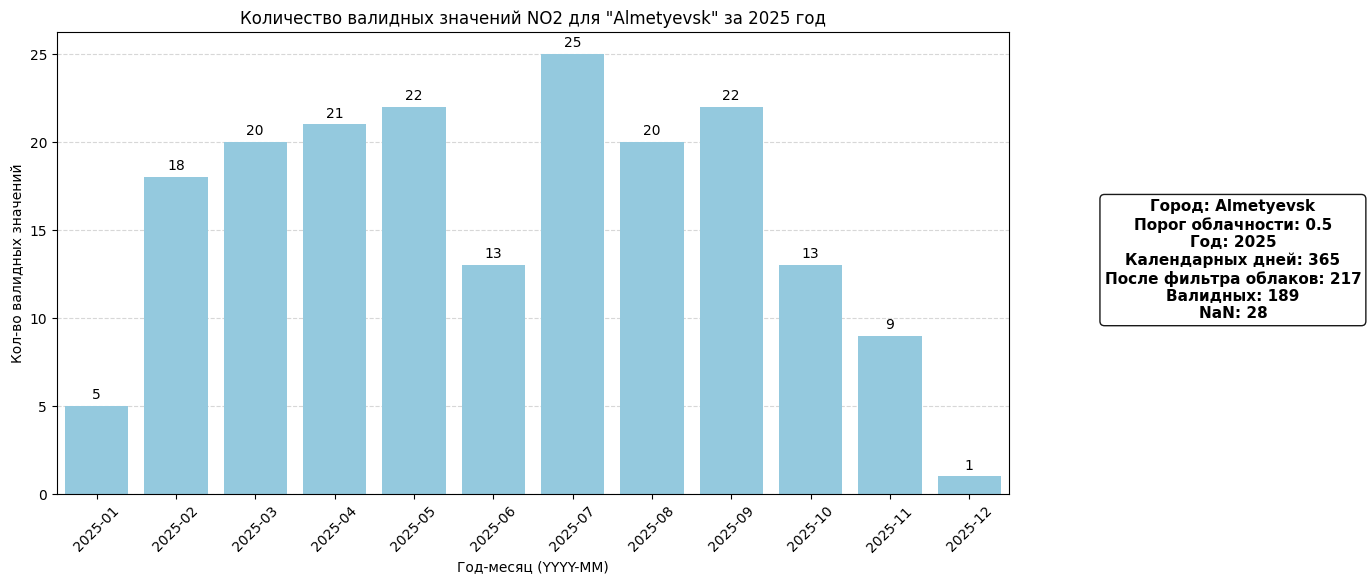

In [28]:
df_plot = df.copy()
df_plot["date"] = pd.to_datetime(df_plot["date"])

# фильтр по городу
df_plot = df_plot[df_plot["city"] == CITY_NAME].copy()

# выбираем год
YEAR = df_plot["date"].dt.year.mode()[0]
df_plot = df_plot[df_plot["date"].dt.year == YEAR]

# календарное количество дней (без фильтра облачности)
calendar_days = len(df_plot)

# применяем фильтр облачности
df_filtered = df_plot[df_plot["cloud_frac_mean"] <= PIXEL_CLOUD_THRESHOLD].copy()

# создаём year_month
df_filtered["year_month"] = df_filtered["date"].dt.to_period("M").astype(str)

# агрегация
monthly = (
    df_filtered.groupby("year_month", as_index=False)
    .agg(
        valid_count=("no2_trop_mean", lambda s: s.notna().sum()),
        total_after_cloud=("no2_trop_mean", "size"),
    )
)

monthly = monthly.sort_values("year_month")

valid_days = df_filtered["no2_trop_mean"].notna().sum()
nan_days = df_filtered["no2_trop_mean"].isna().sum()

info_text = (
    f"Город: {CITY_NAME}\n"
    f"Порог облачности: {PIXEL_CLOUD_THRESHOLD}\n"
    f"Год: {YEAR}\n"
    f"Календарных дней: {calendar_days}\n"
    f"После фильтра облаков: {len(df_filtered)}\n"
    f"Валидных: {valid_days}\n"
    f"NaN: {nan_days}"
)

# построение
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplots_adjust(right=0.72)

sns.barplot(
    data=monthly,
    x="year_month",
    y="valid_count",
    color="skyblue",
    ax=ax
)

ax.set_title(f'Количество валидных значений NO2 для "{CITY_NAME}" за {YEAR} год')
ax.set_xlabel("Год-месяц (YYYY-MM)")
ax.set_ylabel("Кол-во валидных значений")

ax.grid(True, axis="y", linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3)

ax.tick_params(axis="x", rotation=45)

# инфоблок жирным и по центру правой области
fig.text(
    0.86, 0.5,
    info_text,
    ha="center",
    va="center",
    fontsize=11,
    fontweight="bold",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

plt.show()

# Коммит для гит

In [ ]:
# --- БЛОК №2: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ (в конце работы) ---

# 1. Проверяем статус (опционально)
!git status

# 2. ДОБАВЛЯЕМ файлы в "коробку" для отправки. Это то, что вы пропустили.
!git add .

# 3. ПОДПИСЫВАЕМ "коробку" (делаем коммит)
!git commit -m "add Alm data-export script"

# 4. ОТПРАВЛЯЕМ "коробку" на GitHub
!git push

Refresh index: 100% (22/22), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   notebooks/RandomForestRegressor_Surgut_AAI.ipynb
	modified:   notebooks/RandomForestRegressor_Surgut_best_predictors.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	data/raw/add_predictors_Alm/
	notebooks/Almetevsk/

no changes added to commit (use "git add" and/or "git commit -a")
[main c26d39d] add Alm data-export script
 5 files changed, 370 insertions(+), 2 deletions(-)
 create mode 100644 data/raw/add_predictors_Alm/Almetyevsk_data_2019_FULL_YEAR.csv
 create mode 100644 notebooks/Almetevsk/data_export_Almetyevsk.ipynb
 create mode 100644 "notebooks/Almetevsk/\320\232\320\276\320\277\320\270\321\217 RandomForestRegressor_Surgut_best_predictors.ipynb"
 rewrite notebooks/Ra